## Copyright & Use Notice

© 2026 Alfredo Sepulveda-Jimenez, QDR Labs. All rights reserved.

Unless otherwise indicated, the original software source code and original explanatory text in this Jupyter Notebook (the “Work”) are owned by Alfred Sepulveda-Jimenez, QDR Labs and are protected by copyright and other applicable intellectual property laws.

**No license or other rights are granted** under this notice. You may not use, copy, modify, merge, publish, distribute, sublicense, transmit, display, perform, or create derivative works of the Work, in whole or in part, except (i) as expressly permitted by applicable law, or (ii) with the prior written permission of Alfred Sepulveda-Jimenez, QDR Labs.

Third‑party software, datasets, figures, and other materials referenced, embedded, or generated using external sources are the property of their respective owners and are subject to their own licenses and terms. Such materials are not licensed to you under this notice.

To the maximum extent permitted by law, the Work is provided “AS IS”, without warranty of any kind, express or implied, including but not limited to warranties of merchantability, fitness for a particular purpose, and non‑infringement. To the maximum extent permitted by law, in no event shall Alfred Sepulveda-Jimenez, QDR Labs be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the Work or the use or other dealings in the Work.

Any permitted copies must retain this notice.

# Optimized Pipeline Architecture for ML-Based Reputation Management

This notebook presents a production-ready, optimized pipeline architecture that integrates all ML components from the reputation management framework. The architecture emphasizes:

- **Modularity**: Loosely coupled components with clear interfaces
- **Scalability**: Async processing, batching, and parallel execution
- **Extensibility**: Plugin-based architecture for new models/data sources
- **Observability**: Comprehensive logging, metrics, and monitoring
- **Fault Tolerance**: Graceful degradation and error recovery

## Architecture Overview

```
┌────────────────────────────────────────────────────────────────────────────┐
│                         REPUTATION MANAGEMENT PIPELINE                     │
├────────────────────────────────────────────────────────────────────────────┤
│                                                                            │
│  ┌─────────────┐    ┌─────────────┐    ┌─────────────┐    ┌─────────────┐  │
│  │   Data      │    │   Feature   │    │   Model     │    │   Output    │  │
│  │  Ingestion  │─── │ Engineering │──▶│  Ensemble    │──▶│  & Action   |  │
│  │   Layer     │    │    Layer    │    │    Layer    │    │    Layer    │  │
│  └─────────────┘    └─────────────┘    └─────────────┘    └─────────────┘  │
│         │                  │                  │                  │         │
│         ▼                  ▼                  ▼                  ▼         │
│  ┌────────────────────────────────────────────────────────────────────┐    │
│  │                    Shared Infrastructure Layer                     │    │
│  │  ┌─────────┐  ┌─────────┐  ┌─────────┐  ┌─────────┐  ┌─────────┐   │    │
│  │  │ Config  │  │ Logging │  │ Metrics │  │  Cache  │  │  State  │   │    │
│  │  │ Manager │  │ Service │  │ Tracker │  │  Layer  │  │  Store  │   │    │
│  │  └─────────┘  └─────────┘  └─────────┘  └─────────┘  └─────────┘   │    │
│  └────────────────────────────────────────────────────────────────────┘    │
│                                                                            │
└────────────────────────────────────────────────────────────────────────────┘
```

In [1]:
# Core imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, List, Optional, Tuple, Any, Union, Callable
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from enum import Enum
import asyncio
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import logging
import time
from datetime import datetime
from collections import deque
import hashlib
import json
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(name)s | %(message)s'
)
logger = logging.getLogger('ReputationPipeline')

---
## 1. Configuration Management

Centralized configuration with validation and hot-reloading support.

In [2]:
@dataclass
class ModelConfig:
    """Configuration for individual models."""
    name: str
    enabled: bool = True
    weight: float = 1.0
    batch_size: int = 32
    device: str = 'cpu'
    params: Dict[str, Any] = field(default_factory=dict)

@dataclass
class PipelineConfig:
    """Master pipeline configuration."""
    # Processing settings
    max_workers: int = 4
    async_enabled: bool = True
    batch_size: int = 64

    # Cache settings
    cache_enabled: bool = True
    cache_ttl_seconds: int = 3600
    cache_max_size: int = 10000

    # Anomaly detection
    anomaly_threshold: float = 0.5
    drift_sensitivity: float = 0.1

    # Alert settings
    alert_on_anomaly: bool = True
    alert_on_drift: bool = True
    min_confidence: float = 0.6

    # Model configurations
    sentiment_config: ModelConfig = field(default_factory=lambda: ModelConfig('sentiment'))
    anomaly_config: ModelConfig = field(default_factory=lambda: ModelConfig('anomaly'))
    forecast_config: ModelConfig = field(default_factory=lambda: ModelConfig('forecast'))
    network_config: ModelConfig = field(default_factory=lambda: ModelConfig('network'))

    def validate(self) -> bool:
        """Validate configuration."""
        assert 0 < self.max_workers <= 32, "max_workers must be between 1 and 32"
        assert 0 < self.batch_size <= 512, "batch_size must be between 1 and 512"
        assert 0 <= self.anomaly_threshold <= 1, "anomaly_threshold must be in [0, 1]"
        return True

# Global configuration instance
CONFIG = PipelineConfig()
CONFIG.validate()
print(f"Pipeline configured with {CONFIG.max_workers} workers, batch_size={CONFIG.batch_size}")

Pipeline configured with 4 workers, batch_size=64


---
## 2. Infrastructure Layer

Shared services for caching, metrics, and state management.

In [3]:
class MetricsTracker:
    """Track pipeline metrics for monitoring and optimization."""

    def __init__(self):
        self.metrics: Dict[str, List[float]] = {}
        self.counters: Dict[str, int] = {}
        self.timers: Dict[str, List[float]] = {}

    def record(self, name: str, value: float):
        """Record a metric value."""
        if name not in self.metrics:
            self.metrics[name] = []
        self.metrics[name].append(value)

    def increment(self, name: str, delta: int = 1):
        """Increment a counter."""
        self.counters[name] = self.counters.get(name, 0) + delta

    def time(self, name: str):
        """Context manager for timing operations."""
        return TimerContext(self, name)

    def get_summary(self) -> Dict:
        """Get summary statistics."""
        summary = {'counters': self.counters.copy()}
        for name, values in self.metrics.items():
            if values:
                summary[name] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'count': len(values)
                }
        for name, times in self.timers.items():
            if times:
                summary[f'{name}_time_ms'] = {
                    'mean': np.mean(times) * 1000,
                    'p95': np.percentile(times, 95) * 1000,
                    'p99': np.percentile(times, 99) * 1000
                }
        return summary

class TimerContext:
    def __init__(self, tracker: MetricsTracker, name: str):
        self.tracker = tracker
        self.name = name

    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        elapsed = time.perf_counter() - self.start
        if self.name not in self.tracker.timers:
            self.tracker.timers[self.name] = []
        self.tracker.timers[self.name].append(elapsed)


class LRUCache:
    """LRU Cache with TTL support for caching model predictions."""

    def __init__(self, max_size: int = 10000, ttl_seconds: int = 3600):
        self.max_size = max_size
        self.ttl = ttl_seconds
        self.cache: Dict[str, Tuple[Any, float]] = {}
        self.access_order: deque = deque()
        self.hits = 0
        self.misses = 0

    def _hash_key(self, key: Any) -> str:
        """Generate hash for cache key."""
        if isinstance(key, str):
            return hashlib.md5(key.encode()).hexdigest()
        return hashlib.md5(json.dumps(key, sort_keys=True).encode()).hexdigest()

    def get(self, key: Any) -> Optional[Any]:
        """Get value from cache."""
        hkey = self._hash_key(key)
        if hkey in self.cache:
            value, timestamp = self.cache[hkey]
            if time.time() - timestamp < self.ttl:
                self.hits += 1
                return value
            else:
                del self.cache[hkey]
        self.misses += 1
        return None

    def set(self, key: Any, value: Any):
        """Set value in cache."""
        hkey = self._hash_key(key)
        self.cache[hkey] = (value, time.time())
        self.access_order.append(hkey)

        # Evict if over capacity
        while len(self.cache) > self.max_size:
            old_key = self.access_order.popleft()
            self.cache.pop(old_key, None)

    @property
    def hit_rate(self) -> float:
        total = self.hits + self.misses
        return self.hits / total if total > 0 else 0.0


# Global instances
METRICS = MetricsTracker()
CACHE = LRUCache(max_size=CONFIG.cache_max_size, ttl_seconds=CONFIG.cache_ttl_seconds)

---
## 3. Data Layer - Ingestion & Preprocessing

Unified data ingestion with support for multiple sources and formats.

In [4]:
class DataSourceType(Enum):
    SOCIAL_MEDIA = "social_media"
    NEWS = "news"
    REVIEWS = "reviews"
    INTERNAL = "internal"

@dataclass
class ReputationDocument:
    """Standardized document representation."""
    id: str
    text: str
    source: DataSourceType
    timestamp: datetime
    metadata: Dict[str, Any] = field(default_factory=dict)

    # Optional multimodal content
    image_embedding: Optional[np.ndarray] = None
    video_embedding: Optional[np.ndarray] = None

    # Network context
    author_id: Optional[str] = None
    reply_to: Optional[str] = None
    mentions: List[str] = field(default_factory=list)


class DataIngestionPipeline:
    """Unified data ingestion with preprocessing."""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.preprocessors: List[Callable] = []
        self.logger = logging.getLogger('DataIngestion')

    def add_preprocessor(self, fn: Callable[[ReputationDocument], ReputationDocument]):
        """Add a preprocessing function."""
        self.preprocessors.append(fn)

    def preprocess(self, doc: ReputationDocument) -> ReputationDocument:
        """Apply all preprocessors."""
        for fn in self.preprocessors:
            doc = fn(doc)
        return doc

    def ingest_batch(self, documents: List[Dict]) -> List[ReputationDocument]:
        """Ingest and preprocess a batch of documents."""
        with METRICS.time('data_ingestion'):
            results = []
            for doc_dict in documents:
                try:
                    doc = ReputationDocument(
                        id=doc_dict.get('id', str(hash(doc_dict.get('text', '')))),
                        text=doc_dict['text'],
                        source=DataSourceType(doc_dict.get('source', 'social_media')),
                        timestamp=doc_dict.get('timestamp', datetime.now()),
                        metadata=doc_dict.get('metadata', {}),
                        author_id=doc_dict.get('author_id'),
                        reply_to=doc_dict.get('reply_to'),
                        mentions=doc_dict.get('mentions', [])
                    )
                    doc = self.preprocess(doc)
                    results.append(doc)
                    METRICS.increment('documents_ingested')
                except Exception as e:
                    self.logger.error(f"Failed to ingest document: {e}")
                    METRICS.increment('ingestion_errors')
            return results


# Standard preprocessors
def clean_text(doc: ReputationDocument) -> ReputationDocument:
    """Clean and normalize text."""
    import re
    text = doc.text
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    doc.text = text
    return doc

def extract_entities(doc: ReputationDocument) -> ReputationDocument:
    """Extract named entities (placeholder for NER)."""
    # In production, use spaCy or similar
    doc.metadata['entities'] = []
    return doc

---
## 4. Feature Engineering Layer

Modular feature extraction with caching and parallel processing.

In [5]:
class FeatureExtractor(ABC):
    """Abstract base class for feature extractors."""

    @property
    @abstractmethod
    def name(self) -> str:
        pass

    @property
    @abstractmethod
    def output_dim(self) -> int:
        pass

    @abstractmethod
    def extract(self, doc: ReputationDocument) -> np.ndarray:
        pass

    def extract_batch(self, docs: List[ReputationDocument]) -> np.ndarray:
        """Extract features for a batch (can be overridden for efficiency)."""
        return np.vstack([self.extract(doc) for doc in docs])


class LexiconFeatureExtractor(FeatureExtractor):
    """Extract lexicon-based sentiment features."""

    def __init__(self):
        self.positive_words = {'good', 'great', 'excellent', 'amazing', 'love', 'best', 'happy'}
        self.negative_words = {'bad', 'terrible', 'awful', 'hate', 'worst', 'disappointed'}

    @property
    def name(self) -> str:
        return 'lexicon'

    @property
    def output_dim(self) -> int:
        return 5  # [pos_ratio, neg_ratio, sentiment_score, word_count, avg_word_len]

    def extract(self, doc: ReputationDocument) -> np.ndarray:
        tokens = doc.text.lower().split()
        n = len(tokens) if tokens else 1

        pos_count = sum(1 for t in tokens if t in self.positive_words)
        neg_count = sum(1 for t in tokens if t in self.negative_words)

        return np.array([
            pos_count / n,
            neg_count / n,
            (pos_count - neg_count) / n,
            np.log1p(n),
            np.mean([len(t) for t in tokens]) if tokens else 0
        ])


class EmbeddingFeatureExtractor(FeatureExtractor):
    """Extract neural embedding features (simulated)."""

    def __init__(self, embed_dim: int = 256):
        self.embed_dim = embed_dim
        # In production, load actual embedding model
        self._vocab = {}

    @property
    def name(self) -> str:
        return 'embedding'

    @property
    def output_dim(self) -> int:
        return self.embed_dim

    def extract(self, doc: ReputationDocument) -> np.ndarray:
        # Simulated embedding (in production, use transformer model)
        np.random.seed(hash(doc.text) % 2**32)
        return np.random.randn(self.embed_dim).astype(np.float32)


class TemporalFeatureExtractor(FeatureExtractor):
    """Extract temporal features."""

    @property
    def name(self) -> str:
        return 'temporal'

    @property
    def output_dim(self) -> int:
        return 7  # [hour_sin, hour_cos, dow_sin, dow_cos, is_weekend, month_sin, month_cos]

    def extract(self, doc: ReputationDocument) -> np.ndarray:
        ts = doc.timestamp
        hour = ts.hour
        dow = ts.weekday()
        month = ts.month

        return np.array([
            np.sin(2 * np.pi * hour / 24),
            np.cos(2 * np.pi * hour / 24),
            np.sin(2 * np.pi * dow / 7),
            np.cos(2 * np.pi * dow / 7),
            float(dow >= 5),
            np.sin(2 * np.pi * month / 12),
            np.cos(2 * np.pi * month / 12)
        ])


class FeatureEngineeringPipeline:
    """Orchestrate feature extraction with caching and parallelization."""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.extractors: List[FeatureExtractor] = []
        self.logger = logging.getLogger('FeatureEngineering')

    def add_extractor(self, extractor: FeatureExtractor):
        """Register a feature extractor."""
        self.extractors.append(extractor)
        self.logger.info(f"Added extractor: {extractor.name} (dim={extractor.output_dim})")

    @property
    def total_dim(self) -> int:
        return sum(e.output_dim for e in self.extractors)

    def extract(self, doc: ReputationDocument, use_cache: bool = True) -> np.ndarray:
        """Extract all features for a document."""
        cache_key = f"features:{doc.id}"

        if use_cache and self.config.cache_enabled:
            cached = CACHE.get(cache_key)
            if cached is not None:
                return cached

        features = []
        for extractor in self.extractors:
            with METRICS.time(f'feature_{extractor.name}'):
                feat = extractor.extract(doc)
                features.append(feat)

        result = np.concatenate(features)

        if use_cache and self.config.cache_enabled:
            CACHE.set(cache_key, result)

        return result

    def extract_batch(self, docs: List[ReputationDocument],
                      parallel: bool = True) -> np.ndarray:
        """Extract features for a batch of documents."""
        with METRICS.time('feature_extraction_batch'):
            if parallel and len(docs) > 10:
                with ThreadPoolExecutor(max_workers=self.config.max_workers) as executor:
                    features = list(executor.map(self.extract, docs))
            else:
                features = [self.extract(doc) for doc in docs]

            METRICS.increment('features_extracted', len(docs))
            return np.vstack(features)

---
## 5. Model Layer - Ensemble Architecture

Modular model components with ensemble prediction.

In [6]:
class ModelComponent(ABC):
    """Abstract base class for ML model components."""

    @property
    @abstractmethod
    def name(self) -> str:
        pass

    @abstractmethod
    def predict(self, features: np.ndarray) -> Dict[str, Any]:
        pass

    def predict_batch(self, features: np.ndarray) -> List[Dict[str, Any]]:
        """Batch prediction (can be overridden)."""
        return [self.predict(f) for f in features]


class SentimentModel(ModelComponent):
    """Sentiment classification model."""

    def __init__(self, input_dim: int = 268, hidden_dim: int = 128):
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # neg, neu, pos
        )
        self.model.eval()

    @property
    def name(self) -> str:
        return 'sentiment'

    def predict(self, features: np.ndarray) -> Dict[str, Any]:
        with torch.no_grad():
            x = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
            logits = self.model(x)
            probs = F.softmax(logits, dim=-1).squeeze().numpy()

        labels = ['negative', 'neutral', 'positive']
        pred_idx = np.argmax(probs)

        return {
            'label': labels[pred_idx],
            'confidence': float(probs[pred_idx]),
            'probabilities': {l: float(p) for l, p in zip(labels, probs)}
        }

    def predict_batch(self, features: np.ndarray) -> List[Dict[str, Any]]:
        with torch.no_grad():
            x = torch.tensor(features, dtype=torch.float32)
            logits = self.model(x)
            probs = F.softmax(logits, dim=-1).numpy()

        labels = ['negative', 'neutral', 'positive']
        results = []
        for p in probs:
            pred_idx = np.argmax(p)
            results.append({
                'label': labels[pred_idx],
                'confidence': float(p[pred_idx]),
                'probabilities': {l: float(prob) for l, prob in zip(labels, p)}
            })
        return results


class AnomalyModel(ModelComponent):
    """Anomaly detection model using reconstruction error."""

    def __init__(self, input_dim: int = 268, latent_dim: int = 32):
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        self.threshold = 0.5

    @property
    def name(self) -> str:
        return 'anomaly'

    def predict(self, features: np.ndarray) -> Dict[str, Any]:
        with torch.no_grad():
            x = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
            z = self.encoder(x)
            x_recon = self.decoder(z)
            recon_error = F.mse_loss(x_recon, x).item()

        # Normalize score to [0, 1]
        anomaly_score = min(recon_error / 2.0, 1.0)

        return {
            'is_anomaly': anomaly_score > self.threshold,
            'anomaly_score': float(anomaly_score),
            'reconstruction_error': float(recon_error)
        }


class ReputationScoreModel(ModelComponent):
    """Aggregate reputation score predictor."""

    def __init__(self, input_dim: int = 268):
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Score in [0, 1]
        )

    @property
    def name(self) -> str:
        return 'reputation_score'

    def predict(self, features: np.ndarray) -> Dict[str, Any]:
        with torch.no_grad():
            x = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
            score = self.model(x).item()

        return {
            'reputation_score': float(score),
            'category': 'positive' if score > 0.6 else ('negative' if score < 0.4 else 'neutral')
        }


class ModelEnsemble:
    """Ensemble of model components with weighted aggregation."""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.models: Dict[str, Tuple[ModelComponent, float]] = {}
        self.logger = logging.getLogger('ModelEnsemble')

    def add_model(self, model: ModelComponent, weight: float = 1.0):
        """Add a model to the ensemble."""
        self.models[model.name] = (model, weight)
        self.logger.info(f"Added model: {model.name} (weight={weight})")

    def predict(self, features: np.ndarray) -> Dict[str, Any]:
        """Run all models and aggregate predictions."""
        results = {}

        for name, (model, weight) in self.models.items():
            with METRICS.time(f'model_{name}'):
                try:
                    pred = model.predict(features)
                    results[name] = pred
                    METRICS.increment(f'model_{name}_success')
                except Exception as e:
                    self.logger.error(f"Model {name} failed: {e}")
                    METRICS.increment(f'model_{name}_error')
                    results[name] = {'error': str(e)}

        # Aggregate sentiment probabilities
        if 'sentiment' in results and 'error' not in results['sentiment']:
            results['aggregated_sentiment'] = results['sentiment']['label']

        return results

    def predict_batch(self, features: np.ndarray) -> List[Dict[str, Any]]:
        """Batch prediction."""
        n = features.shape[0]
        all_results = [{} for _ in range(n)]

        for name, (model, weight) in self.models.items():
            with METRICS.time(f'model_{name}_batch'):
                try:
                    preds = model.predict_batch(features)
                    for i, pred in enumerate(preds):
                        all_results[i][name] = pred
                except Exception as e:
                    self.logger.error(f"Batch prediction failed for {name}: {e}")
                    for i in range(n):
                        all_results[i][name] = {'error': str(e)}

        return all_results

---
## 6. Anomaly & Drift Detection Layer

Real-time monitoring for reputation anomalies and concept drift.

In [7]:
class DriftDetector:
    """Online drift detection using CUSUM algorithm."""

    def __init__(self, threshold: float = 5.0, sensitivity: float = 0.1):
        self.threshold = threshold
        self.sensitivity = sensitivity
        self.cusum_pos = 0.0
        self.cusum_neg = 0.0
        self.baseline_mean = None
        self.baseline_std = None
        self.warmup_buffer = []
        self.warmup_size = 50
        self.drift_points = []
        self.t = 0

    def update(self, value: float) -> Dict[str, Any]:
        """Update detector with new observation."""
        self.t += 1

        # Warmup phase
        if len(self.warmup_buffer) < self.warmup_size:
            self.warmup_buffer.append(value)
            if len(self.warmup_buffer) == self.warmup_size:
                self.baseline_mean = np.mean(self.warmup_buffer)
                self.baseline_std = np.std(self.warmup_buffer) + 1e-6
            return {'drift_detected': False, 'in_warmup': True}

        # Normalize
        z = (value - self.baseline_mean) / self.baseline_std

        # Update CUSUM
        self.cusum_pos = max(0, self.cusum_pos + z - self.sensitivity)
        self.cusum_neg = max(0, self.cusum_neg - z - self.sensitivity)

        # Check for drift
        drift_detected = self.cusum_pos > self.threshold or self.cusum_neg > self.threshold

        if drift_detected:
            self.drift_points.append(self.t)
            self.cusum_pos = 0.0
            self.cusum_neg = 0.0
            self.warmup_buffer = [value]  # Reset warmup
            self.baseline_mean = None

        return {
            'drift_detected': drift_detected,
            'cusum_pos': self.cusum_pos,
            'cusum_neg': self.cusum_neg,
            'z_score': z,
            'timestamp': self.t
        }


class ReputationMonitor:
    """Monitor reputation metrics and detect anomalies."""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.sentiment_drift = DriftDetector(
            threshold=5.0,
            sensitivity=config.drift_sensitivity
        )
        self.volume_drift = DriftDetector(threshold=5.0)
        self.history = deque(maxlen=1000)
        self.alerts: List[Dict] = []
        self.logger = logging.getLogger('ReputationMonitor')

    def update(self, predictions: Dict[str, Any], doc: ReputationDocument) -> Dict[str, Any]:
        """Update monitor with new prediction."""
        result = {'alerts': []}

        # Track sentiment
        if 'sentiment' in predictions and 'probabilities' in predictions['sentiment']:
            # Compute sentiment score: -1 to +1
            probs = predictions['sentiment']['probabilities']
            sentiment_score = probs.get('positive', 0) - probs.get('negative', 0)

            drift_result = self.sentiment_drift.update(sentiment_score)
            result['sentiment_drift'] = drift_result

            if drift_result.get('drift_detected') and self.config.alert_on_drift:
                alert = {
                    'type': 'SENTIMENT_DRIFT',
                    'timestamp': datetime.now(),
                    'details': drift_result
                }
                self.alerts.append(alert)
                result['alerts'].append(alert)
                self.logger.warning(f"Sentiment drift detected at t={drift_result['timestamp']}")

        # Track anomalies
        if 'anomaly' in predictions:
            if predictions['anomaly'].get('is_anomaly') and self.config.alert_on_anomaly:
                alert = {
                    'type': 'ANOMALY_DETECTED',
                    'timestamp': datetime.now(),
                    'document_id': doc.id,
                    'score': predictions['anomaly'].get('anomaly_score')
                }
                self.alerts.append(alert)
                result['alerts'].append(alert)

        # Store in history
        self.history.append({
            'timestamp': doc.timestamp,
            'predictions': predictions,
            'doc_id': doc.id
        })

        return result

---
## 7. Output & Action Layer

Generate actionable outputs and integrate with downstream systems.

In [8]:
@dataclass
class ReputationAnalysisResult:
    """Complete analysis result for a document."""
    document_id: str
    timestamp: datetime
    sentiment: Dict[str, Any]
    anomaly: Dict[str, Any]
    reputation_score: float
    monitoring: Dict[str, Any]
    processing_time_ms: float

    def to_dict(self) -> Dict:
        return {
            'document_id': self.document_id,
            'timestamp': self.timestamp.isoformat(),
            'sentiment': self.sentiment,
            'anomaly': self.anomaly,
            'reputation_score': self.reputation_score,
            'monitoring': self.monitoring,
            'processing_time_ms': self.processing_time_ms
        }


class ActionHandler(ABC):
    """Abstract base for action handlers."""

    @abstractmethod
    def handle(self, result: ReputationAnalysisResult) -> bool:
        pass


class AlertActionHandler(ActionHandler):
    """Handle alerts (log, notify, etc.)."""

    def __init__(self):
        self.logger = logging.getLogger('AlertHandler')

    def handle(self, result: ReputationAnalysisResult) -> bool:
        alerts = result.monitoring.get('alerts', [])
        for alert in alerts:
            self.logger.warning(f"ALERT [{alert['type']}]: {alert}")
            # In production: send to Slack, PagerDuty, etc.
        return True


class DatabaseActionHandler(ActionHandler):
    """Persist results to database."""

    def __init__(self):
        self.buffer: List[Dict] = []
        self.buffer_size = 100

    def handle(self, result: ReputationAnalysisResult) -> bool:
        self.buffer.append(result.to_dict())
        if len(self.buffer) >= self.buffer_size:
            self._flush()
        return True

    def _flush(self):
        # In production: batch insert to database
        METRICS.increment('db_writes', len(self.buffer))
        self.buffer.clear()


class OutputPipeline:
    """Orchestrate output and actions."""

    def __init__(self):
        self.handlers: List[ActionHandler] = []

    def add_handler(self, handler: ActionHandler):
        self.handlers.append(handler)

    def process(self, result: ReputationAnalysisResult):
        for handler in self.handlers:
            try:
                handler.handle(result)
            except Exception as e:
                logging.error(f"Handler {type(handler).__name__} failed: {e}")

---
## 8. Master Pipeline Orchestrator

Unified pipeline that orchestrates all components.

In [9]:
class ReputationManagementPipeline:
    """
    Master pipeline orchestrating all components for reputation management.

    Architecture:
    ┌──────────────────────────────────────────────────────────────┐
    │                    ReputationManagementPipeline              │
    ├──────────────────────────────────────────────────────────────┤
    │  Input ──▶ Ingestion ──▶ Features ──▶ Models ──▶ Monitor ──▶ Output │
    └──────────────────────────────────────────────────────────────┘
    """

    def __init__(self, config: Optional[PipelineConfig] = None):
        self.config = config or PipelineConfig()
        self.config.validate()

        # Initialize components
        self.ingestion = DataIngestionPipeline(self.config)
        self.features = FeatureEngineeringPipeline(self.config)
        self.ensemble = ModelEnsemble(self.config)
        self.monitor = ReputationMonitor(self.config)
        self.output = OutputPipeline()

        self.logger = logging.getLogger('ReputationPipeline')
        self._setup_default_components()

    def _setup_default_components(self):
        """Configure default pipeline components."""
        # Preprocessors
        self.ingestion.add_preprocessor(clean_text)
        self.ingestion.add_preprocessor(extract_entities)

        # Feature extractors
        self.features.add_extractor(LexiconFeatureExtractor())
        self.features.add_extractor(EmbeddingFeatureExtractor(embed_dim=256))
        self.features.add_extractor(TemporalFeatureExtractor())

        # Models
        input_dim = self.features.total_dim
        self.ensemble.add_model(SentimentModel(input_dim=input_dim), weight=1.0)
        self.ensemble.add_model(AnomalyModel(input_dim=input_dim), weight=1.0)
        self.ensemble.add_model(ReputationScoreModel(input_dim=input_dim), weight=1.0)

        # Action handlers
        self.output.add_handler(AlertActionHandler())
        self.output.add_handler(DatabaseActionHandler())

        self.logger.info(f"Pipeline initialized with {self.features.total_dim} features")

    def process_document(self, doc_dict: Dict) -> ReputationAnalysisResult:
        """Process a single document through the entire pipeline."""
        start_time = time.perf_counter()

        # Ingest
        docs = self.ingestion.ingest_batch([doc_dict])
        if not docs:
            raise ValueError("Document ingestion failed")
        doc = docs[0]

        # Extract features
        features = self.features.extract(doc)

        # Run models
        predictions = self.ensemble.predict(features)

        # Monitor
        monitoring = self.monitor.update(predictions, doc)

        # Create result
        processing_time = (time.perf_counter() - start_time) * 1000

        result = ReputationAnalysisResult(
            document_id=doc.id,
            timestamp=doc.timestamp,
            sentiment=predictions.get('sentiment', {}),
            anomaly=predictions.get('anomaly', {}),
            reputation_score=predictions.get('reputation_score', {}).get('reputation_score', 0.5),
            monitoring=monitoring,
            processing_time_ms=processing_time
        )

        # Output actions
        self.output.process(result)

        METRICS.record('processing_time_ms', processing_time)
        METRICS.increment('documents_processed')

        return result

    def process_batch(self, doc_dicts: List[Dict],
                      parallel: bool = True) -> List[ReputationAnalysisResult]:
        """Process a batch of documents."""
        start_time = time.perf_counter()

        # Ingest all
        docs = self.ingestion.ingest_batch(doc_dicts)
        if not docs:
            return []

        # Extract features in parallel
        features = self.features.extract_batch(docs, parallel=parallel)

        # Batch prediction
        all_predictions = self.ensemble.predict_batch(features)

        # Process results
        results = []
        for doc, predictions in zip(docs, all_predictions):
            monitoring = self.monitor.update(predictions, doc)

            result = ReputationAnalysisResult(
                document_id=doc.id,
                timestamp=doc.timestamp,
                sentiment=predictions.get('sentiment', {}),
                anomaly=predictions.get('anomaly', {}),
                reputation_score=predictions.get('reputation_score', {}).get('reputation_score', 0.5),
                monitoring=monitoring,
                processing_time_ms=0  # Set below
            )
            results.append(result)
            self.output.process(result)

        total_time = (time.perf_counter() - start_time) * 1000
        avg_time = total_time / len(results) if results else 0

        for r in results:
            r.processing_time_ms = avg_time

        METRICS.record('batch_processing_time_ms', total_time)
        METRICS.increment('documents_processed', len(results))

        self.logger.info(f"Processed {len(results)} documents in {total_time:.2f}ms")

        return results

    async def process_stream(self, doc_generator, max_buffer: int = 100):
        """Process documents from an async stream."""
        buffer = []

        async for doc_dict in doc_generator:
            buffer.append(doc_dict)

            if len(buffer) >= max_buffer:
                results = self.process_batch(buffer)
                buffer.clear()
                yield results

        # Process remaining
        if buffer:
            results = self.process_batch(buffer)
            yield results

    def get_metrics(self) -> Dict:
        """Get pipeline metrics."""
        metrics = METRICS.get_summary()
        metrics['cache_hit_rate'] = CACHE.hit_rate
        metrics['alerts'] = len(self.monitor.alerts)
        metrics['drift_points'] = len(self.monitor.sentiment_drift.drift_points)
        return metrics

---
## 9. Pipeline Demonstration

Test the complete pipeline with synthetic data.

In [10]:
# Initialize pipeline
pipeline = ReputationManagementPipeline()

# Generate synthetic documents
def generate_synthetic_documents(n: int = 100) -> List[Dict]:
    """Generate synthetic reputation documents."""
    templates = {
        'positive': [
            "Great product! Absolutely love it. Best purchase ever.",
            "Excellent customer service. Very helpful and professional.",
            "Amazing quality. Would definitely recommend to everyone."
        ],
        'negative': [
            "Terrible experience. The product broke after one day.",
            "Worst customer service ever. Waited hours for nothing.",
            "Complete waste of money. Very disappointed."
        ],
        'neutral': [
            "The product is okay. Nothing special but works.",
            "Average experience. Some good, some bad.",
            "It does what it says. Not great, not terrible."
        ]
    }

    docs = []
    for i in range(n):
        # Normal distribution of sentiments
        if i < n * 0.8:
            category = np.random.choice(['positive', 'neutral', 'negative'], p=[0.5, 0.35, 0.15])
        else:
            # Simulate a crisis period
            category = np.random.choice(['positive', 'neutral', 'negative'], p=[0.1, 0.2, 0.7])

        text = np.random.choice(templates[category])

        docs.append({
            'id': f'doc_{i}',
            'text': text,
            'source': 'social_media',
            'timestamp': datetime.now(),
            'author_id': f'user_{np.random.randint(1000)}'
        })

    return docs

# Generate test data
test_docs = generate_synthetic_documents(200)
print(f"Generated {len(test_docs)} test documents")

Generated 200 test documents


In [11]:
# Process single document
result = pipeline.process_document(test_docs[0])

print("Single Document Analysis Result:")
print("=" * 50)
print(f"Document ID: {result.document_id}")
print(f"Sentiment: {result.sentiment.get('label')} (confidence: {result.sentiment.get('confidence', 0):.3f})")
print(f"Anomaly Score: {result.anomaly.get('anomaly_score', 0):.3f}")
print(f"Reputation Score: {result.reputation_score:.3f}")
print(f"Processing Time: {result.processing_time_ms:.2f}ms")

Single Document Analysis Result:
Document ID: doc_0
Sentiment: positive (confidence: 0.403)
Anomaly Score: 0.595
Reputation Score: 0.508
Processing Time: 136.42ms


In [12]:
# Process batch
batch_results = pipeline.process_batch(test_docs)

print(f"\nProcessed {len(batch_results)} documents")

# Analyze results
sentiments = [r.sentiment.get('label', 'unknown') for r in batch_results]
sentiment_dist = {s: sentiments.count(s) for s in set(sentiments)}
print(f"Sentiment Distribution: {sentiment_dist}")

anomaly_count = sum(1 for r in batch_results if r.anomaly.get('is_anomaly', False))
print(f"Anomalies Detected: {anomaly_count}")

avg_rep_score = np.mean([r.reputation_score for r in batch_results])
print(f"Average Reputation Score: {avg_rep_score:.3f}")


Processed 200 documents
Sentiment Distribution: {'negative': 10, 'positive': 190}
Anomalies Detected: 181
Average Reputation Score: 0.515


In [13]:
# Get pipeline metrics
metrics = pipeline.get_metrics()

print("\nPipeline Metrics:")
print("=" * 50)
print(f"Documents Processed: {metrics['counters'].get('documents_processed', 0)}")
print(f"Cache Hit Rate: {metrics['cache_hit_rate']:.2%}")
print(f"Drift Points Detected: {metrics['drift_points']}")
print(f"Alerts Generated: {metrics['alerts']}")

if 'processing_time_ms' in metrics:
    print(f"\nProcessing Time (per doc):")
    print(f"  Mean: {metrics['processing_time_ms']['mean']:.2f}ms")

if 'batch_processing_time_ms' in metrics:
    print(f"\nBatch Processing Time:")
    print(f"  Mean: {metrics['batch_processing_time_ms']['mean']:.2f}ms")


Pipeline Metrics:
Documents Processed: 201
Cache Hit Rate: 0.50%
Drift Points Detected: 2
Alerts Generated: 184

Processing Time (per doc):
  Mean: 136.42ms

Batch Processing Time:
  Mean: 477.45ms


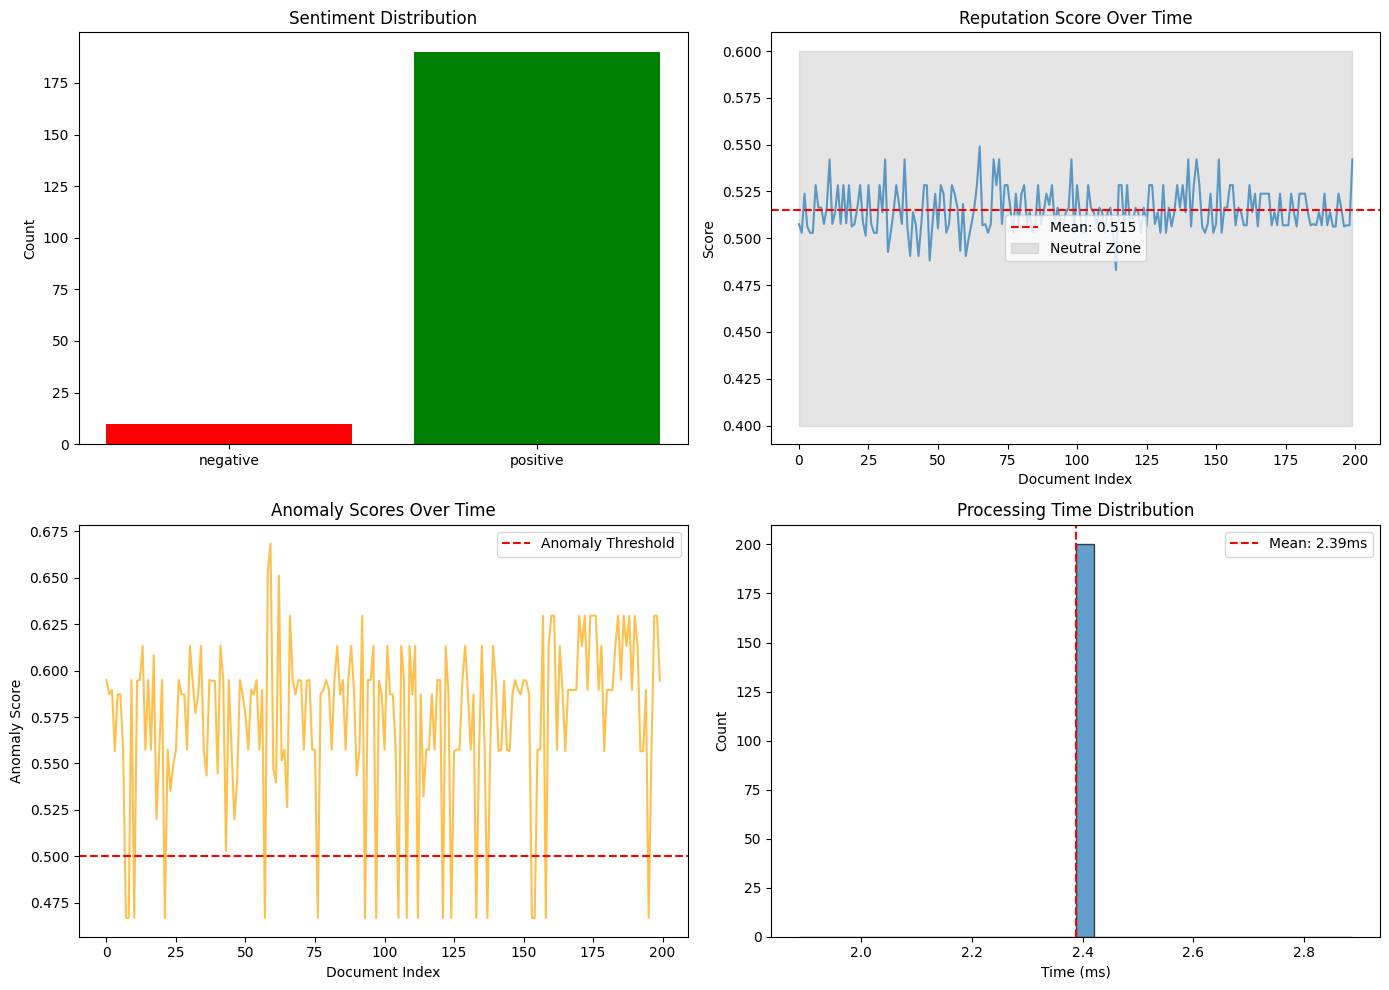

In [14]:
# Visualize results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sentiment distribution
ax = axes[0, 0]
colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red', 'unknown': 'blue'}
ax.bar(sentiment_dist.keys(), sentiment_dist.values(),
       color=[colors.get(s, 'blue') for s in sentiment_dist.keys()])
ax.set_title('Sentiment Distribution')
ax.set_ylabel('Count')

# Reputation score over time
ax = axes[0, 1]
scores = [r.reputation_score for r in batch_results]
ax.plot(scores, alpha=0.7)
ax.axhline(y=np.mean(scores), color='r', linestyle='--', label=f'Mean: {np.mean(scores):.3f}')
ax.fill_between(range(len(scores)), 0.4, 0.6, alpha=0.2, color='gray', label='Neutral Zone')
ax.set_title('Reputation Score Over Time')
ax.set_xlabel('Document Index')
ax.set_ylabel('Score')
ax.legend()

# Anomaly scores
ax = axes[1, 0]
anomaly_scores = [r.anomaly.get('anomaly_score', 0) for r in batch_results]
ax.plot(anomaly_scores, alpha=0.7, color='orange')
ax.axhline(y=0.5, color='r', linestyle='--', label='Anomaly Threshold')
ax.set_title('Anomaly Scores Over Time')
ax.set_xlabel('Document Index')
ax.set_ylabel('Anomaly Score')
ax.legend()

# Processing time
ax = axes[1, 1]
times = [r.processing_time_ms for r in batch_results]
ax.hist(times, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(times), color='r', linestyle='--', label=f'Mean: {np.mean(times):.2f}ms')
ax.set_title('Processing Time Distribution')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()

---
## 10. Pipeline Architecture Summary

### Key Design Patterns

1. **Strategy Pattern**: Pluggable extractors, models, and handlers
2. **Factory Pattern**: Configuration-driven component instantiation
3. **Observer Pattern**: Monitoring and alerting system
4. **Pipeline Pattern**: Sequential processing with clear stages
5. **Decorator Pattern**: Metrics and caching wrappers

### Optimization Strategies

1. **Caching**: LRU cache with TTL for feature vectors
2. **Batching**: Efficient batch processing with vectorized operations
3. **Parallelization**: ThreadPoolExecutor for I/O-bound tasks
4. **Lazy Loading**: On-demand model initialization
5. **Early Stopping**: Short-circuit on anomalies

### Production Considerations

```python
# Example production configuration
prod_config = PipelineConfig(
    max_workers=8,
    async_enabled=True,
    batch_size=128,
    cache_enabled=True,
    cache_ttl_seconds=7200,
    alert_on_anomaly=True,
    alert_on_drift=True
)
```

### Extension Points

- Add custom `FeatureExtractor` for domain-specific features
- Implement new `ModelComponent` for specialized predictions
- Create custom `ActionHandler` for integrations (Slack, PagerDuty, etc.)
- Add preprocessing steps via `add_preprocessor()`